# 프로젝트 : 주식 예측에 도전해 보자

* 실제 주식값 예측에 도전

우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측.  
이를 위해서 "samsung"을 검색하시고, "Historical Data" 탭에서 "Time Period"를 "Max"로 선택, "Apply" 버튼을 눌러 과거 삼성전자가 상장한 시점부터 가장 최근까지의 자료를 조회.  
"Download"를 클릭하면 데이터를 다운로드.  
다운로드가 완료되었다면 대략 다음과 같이 작업 디렉토리로 파일을 옮겨 주세요. 실습환경에 따라 원본(source)과 사본(destination) 경로는 달라질 수 있습니다.

In [1]:
#$ mv ~/Downloads/005930.KS.csv ~/aiffel/stock_prediction/data

## 1. 시계열 데이터 준비

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume  
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만,  
우리는 Close만 사용

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

data = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'

In [3]:
pd.read_csv(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4761.183105,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4348.184082,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4379.354004,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4317.015625,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4496.240723,46880000.0
...,...,...,...,...,...,...,...
5314,2021-02-23,81200.0,82900.0,81100.0,82000.0,82000.000000,20587314.0
5315,2021-02-24,81800.0,83600.0,81300.0,82000.0,82000.000000,26807651.0
5316,2021-02-25,84000.0,85400.0,83000.0,85300.0,85300.000000,34155986.0
5317,2021-02-26,82800.0,83400.0,82000.0,82500.0,82500.000000,38520800.0


In [4]:
# parse_dates 
df = pd.read_csv(data, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

## 2. 각종 전처리 수행

* 결측치 처리

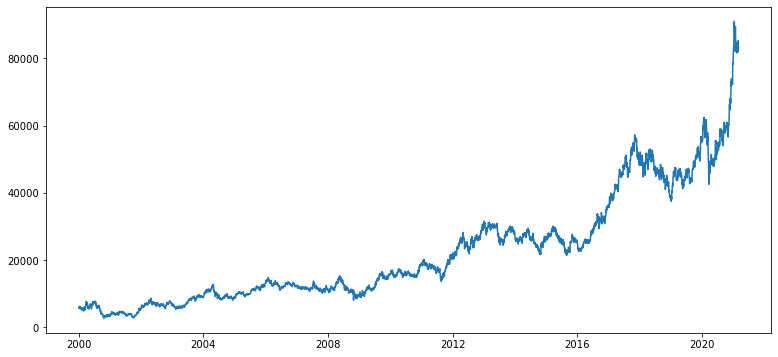

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    
plt.plot(ts)
# 기본적인 삼성데이터

In [6]:
ts[ts.isna()]

Date
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [7]:
# 결측치 선형으로 보간
ts1=ts.interpolate(method='time')
print(ts1[ts1.isna()])
# Nan 없다.

Series([], Name: Close, dtype: float64)


* 로그 변환

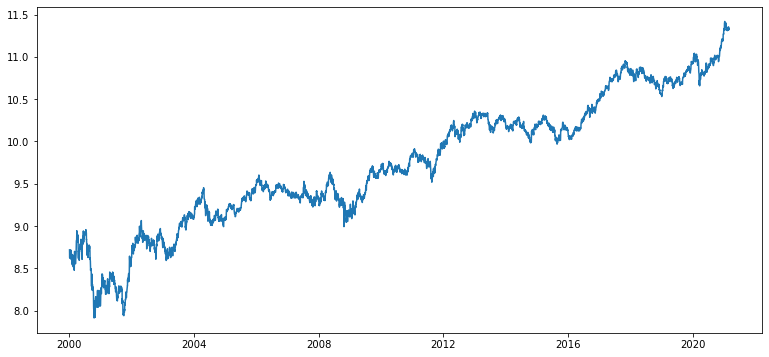

In [8]:
ts_log = np.log(ts1)
plt.plot(ts_log)
# 그래프가 좀 완만해졌다.

## 시계열 안정성 분석

-정성적 그래프 분석  
-정량적 Augmented Dicky-Fuller Test  
-시계열 분해(Time Series Decomposition)  
-Residual 안정성 확인  

* 정성적 그래프 분석

In [9]:
# 정성적
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [10]:
from statsmodels.tsa.stattools import adfuller

# 정량적
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [11]:
adfuller(ts_log, autolag='AIC')

(-0.3071994571759624,
 0.9244784662757132,
 4,
 5314,
 {'1%': -3.431581174565048,
  '5%': -2.862084053101465,
  '10%': -2.5670595989092377},
 -25175.53006298418)

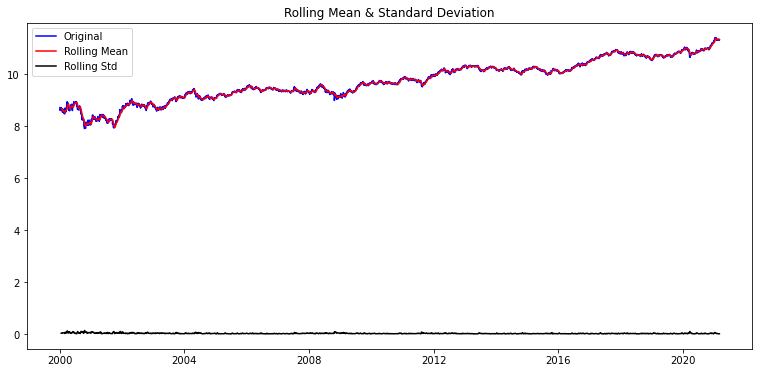

Results of Dickey-Fuller Test:
Test Statistic                   -0.307199
p-value                           0.924478
#Lags Used                        4.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


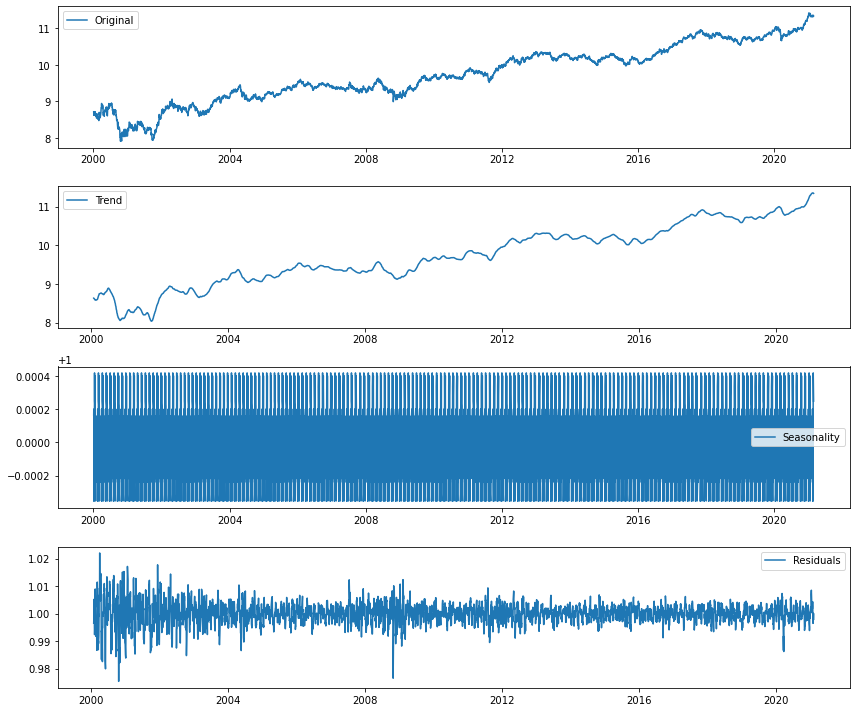

In [12]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)
# 시계열이 안정적이지 않다에 대해, 
# p-value가 1에 근접, 가설을 기각하진 않지만, 안정적인지는 모른다.

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# windows = 겹치지 않는 지역
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (12,10)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals') # ori - trend - Season
plt.legend(loc='best')
plt.tight_layout()

In [13]:
residual.value_counts(), residual.nunique()

(1.001172    1
 0.998327    1
 1.001502    1
 1.000736    1
 1.004442    1
            ..
 1.000417    1
 1.002683    1
 1.001895    1
 0.997165    1
 0.997198    1
 Name: resid, Length: 5289, dtype: int64,
 5289)

In [14]:
residual.isna().sum()

30

In [15]:
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# p-value값이 매우 작아졌다. 시계열이 안정적이지 않다는 가설 기각 가능

Results of Dickey-Fuller Test:
Test Statistic                -1.761315e+01
p-value                        3.870796e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.255000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


## 학습, 테스트 데이터셋 생성

* 학습, 테스트셋 분리

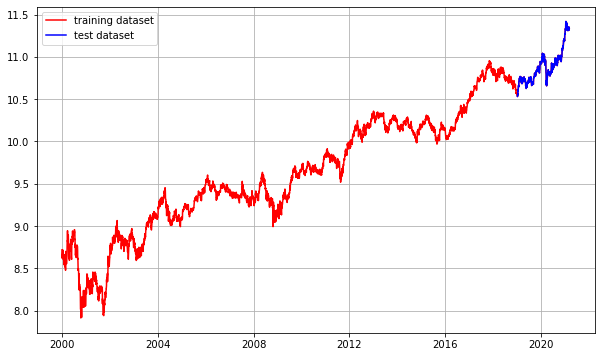

In [16]:
# 시계열데이터라 결과가 그래프로 표현가능하도록 일정비율 사용
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True) # 격자
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 적정 ARIMA 모수 찾기

ACF, PACF 그려보기 -> p,q 구하기  
차분 안정성 확인 -> d 구하기

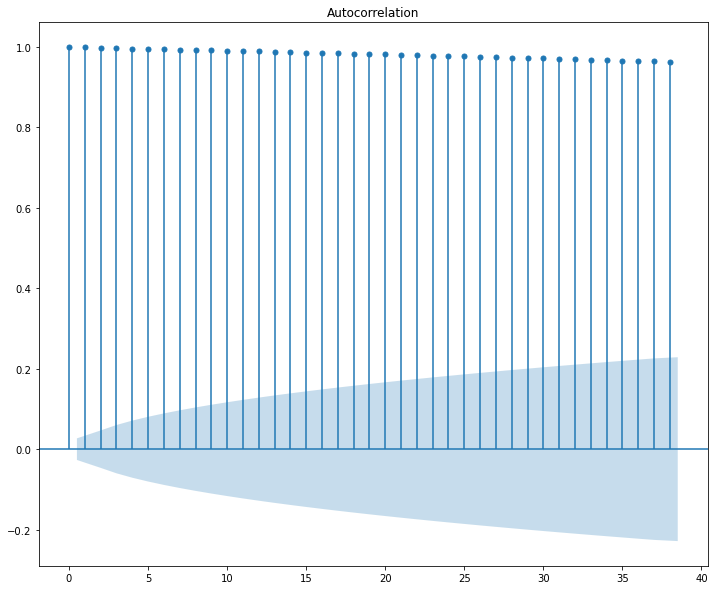

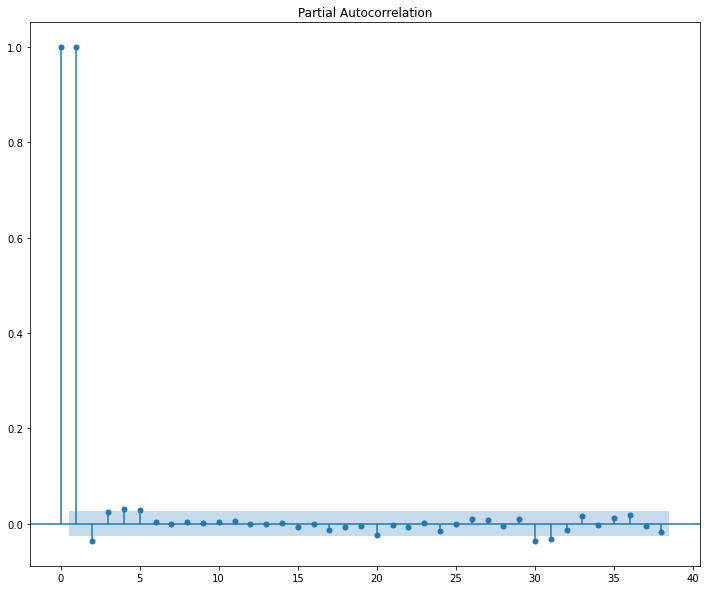

In [17]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# [[YOUR CODE]]
plot_acf(ts_log)   
plot_pacf(ts_log)  
plt.show()
# acf 천천히 감소
# pcaf 절단값 2? AR(2)? q=?,0사용?

* 차분 안정성 확인 -> d 구하기

In [18]:
ts_log

Date
2000-01-04     8.717682
2000-01-05     8.626944
2000-01-06     8.634087
2000-01-07     8.619750
2000-01-10     8.660427
                ...    
2021-02-23    11.314475
2021-02-24    11.314475
2021-02-25    11.353930
2021-02-26    11.320554
2021-03-02    11.331404
Name: Close, Length: 5319, dtype: float64

In [19]:
ts_log.iloc[1:]

Date
2000-01-05     8.626944
2000-01-06     8.634087
2000-01-07     8.619750
2000-01-10     8.660427
2000-01-11     8.660427
                ...    
2021-02-23    11.314475
2021-02-24    11.314475
2021-02-25    11.353930
2021-02-26    11.320554
2021-03-02    11.331404
Name: Close, Length: 5318, dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                  -40.104684
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5314.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


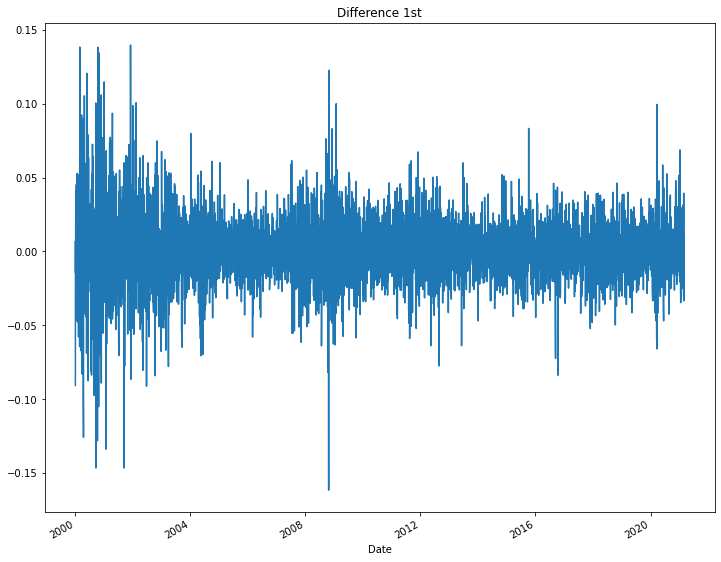

In [20]:
# 1차 차분 구하기
# 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법 = iloc[1:]
# period = 계산위해 이동할 기간(1스탭 몇일)
diff_1 = ts_log.diff(periods=1).iloc[1:] 
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 1차 차분에서 안정적이지 않다?의  pvalue 0.0에 근접, >>반대:안정적이다 검증

## ARIMA 모델 훈련과 테스트

ARIMA 모델 빌드와 훈련  
모델 테스트 및 플로팅  
최종 예측 모델 정확도 측정(MAPE)

* ARIMA 모델 빌드와 훈련

In [21]:
# p=2, q=0, d=1

from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(5, 0, 1))
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/ssac26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4787
Model:                     ARMA(5, 1)   Log Likelihood               11301.432
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 02 Mar 2021   AIC                         -22586.864
Time:                        20:57:56   BIC                         -22535.074
Sample:                             0   HQIC                        -22568.672
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.6168      0.603     15.961      0.000       8.436      10.798
ar.L1.Close     1.4189      0.006    229.015      0.000       1.407       1.431
ar.L2.Close    -0.5101      0.013    -39.535    

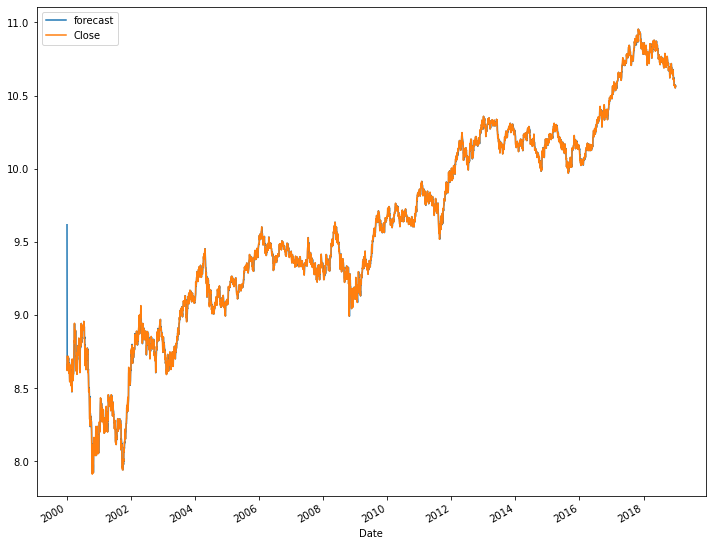

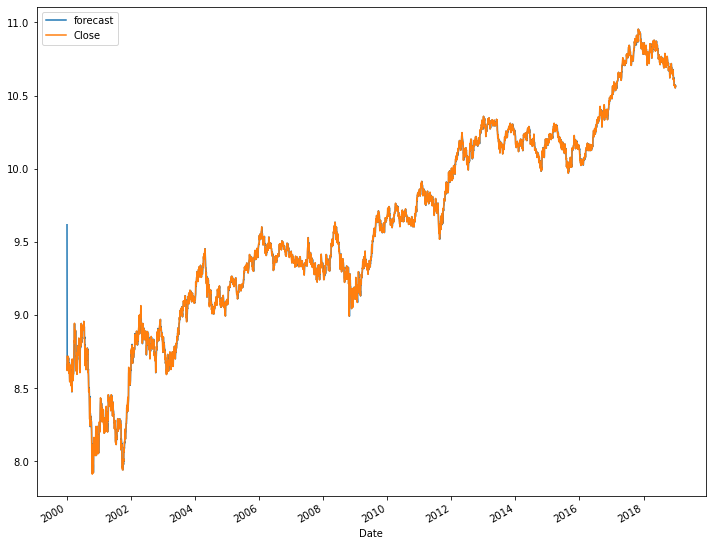

In [22]:
fitted_m.plot_predict()

* 모델 테스트 및 플로팅

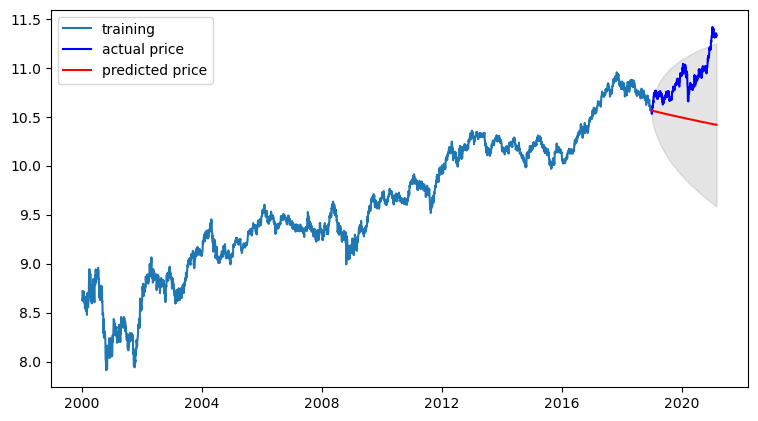

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [24]:
# 테스트데이터는 상승했지만 예측결과는 하락으로 나옴

* 최종 예측 모델 정확도 측정(MAPE)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
# mape는 mape*100을 한 백분률로도 가능?

MSE:  497709955.7852246
MAE:  18400.167787408853
RMSE:  22309.41406189828
MAPE: 31.02%


In [26]:
# mape33%로 삼성주식데이터는 예측실패
# p값을 1로 바꿔도 MAPE감소 안함

# ARIMA(order =(p,d,q))로 설명엔 되어있는데, 노드엔 pqd순서로 되어있음
# 인터넷검색도 pdq순서인데 모델에 pdq순서 입력시 에러 발생해서 pqd로 작업함

'\npacf가 0에 처음으로 근접하는 값의 앞을 p로 사용 (p=5)\n19% 정도의 수치가 나옴\n'

## 다른 주식종목 예측해보기 - 대한항공

In [27]:
korair = os.getenv('HOME') + '/aiffel/stock_prediction/data/003490.KS.csv'
air = pd.read_csv(korair, index_col='Date', parse_dates=True)
air = air['Close']

air.head()

Date
2000-01-04    11778.267578
2000-01-05    13075.873047
2000-01-06    11578.635742
2000-01-07    11977.899414
2000-01-10    11728.359375
Name: Close, dtype: float64

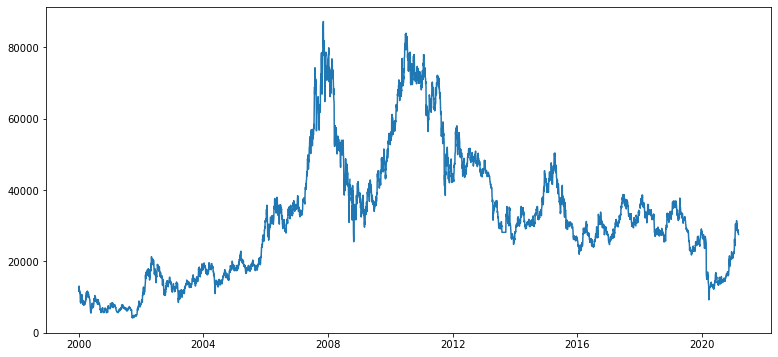

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    
plt.plot(air)
# 기본적인 종가차트

In [29]:
air[air.isna()]

Date
2005-01-03   NaN
2008-05-01   NaN
2008-05-05   NaN
2008-05-12   NaN
2008-06-06   NaN
2008-08-15   NaN
2008-09-15   NaN
2008-10-03   NaN
2008-12-25   NaN
2008-12-31   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [30]:
# nan 보간
# 결측치 선형으로 보간
air1=air.interpolate(method='time')
print(air1[air1.isna()])
# Nan 없다.

Series([], Name: Close, dtype: float64)


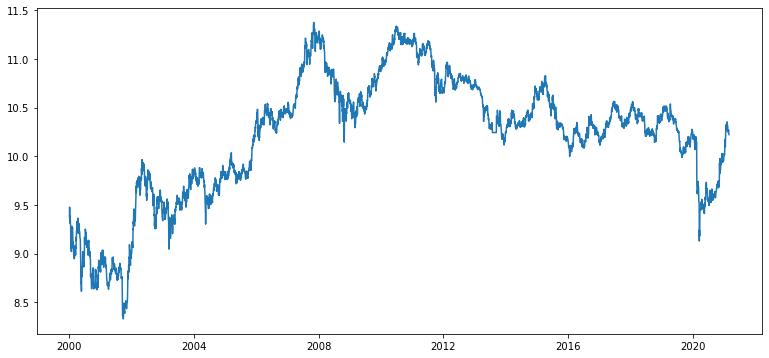

In [31]:
air_log = np.log(air1)
plt.plot(air_log)

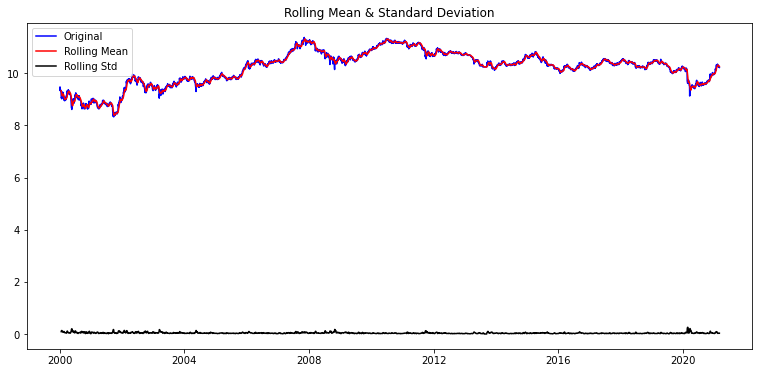

Results of Dickey-Fuller Test:
Test Statistic                   -1.992354
p-value                           0.289936
#Lags Used                       21.000000
Number of Observations Used    5297.000000
Critical Value (1%)              -3.431585
Critical Value (5%)              -2.862086
Critical Value (10%)             -2.567061
dtype: float64


In [32]:
plot_rolling_statistics(air_log, window=12)
#정량적 
augmented_dickey_fuller_test(air_log)
# 시계열이 안정적인가? >>p값이 0.05이상 >> 못써먹음

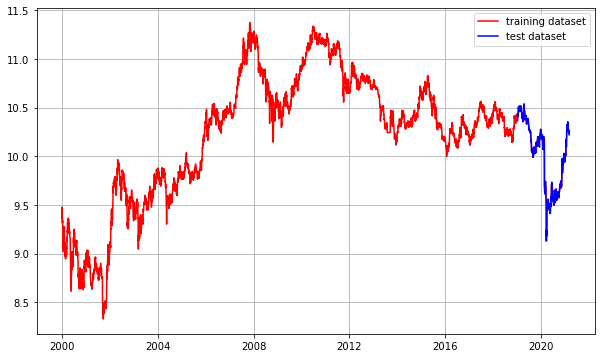

In [33]:
# 시계열데이터라 결과가 그래프로 표현가능하도록 일정비율 사용
train_data_air, test_data_air = air_log[:int(len(air_log)*0.9)], air_log[int(len(air_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True) # 격자
plt.plot(air_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_air, c='b', label='test dataset')
plt.legend()

In [34]:
print(air_log[:2])
print(train_data_air.shape)
print(test_data_air.shape)

Date
2000-01-04    9.374011
2000-01-05    9.478524
Name: Close, dtype: float64
(4787,)
(532,)


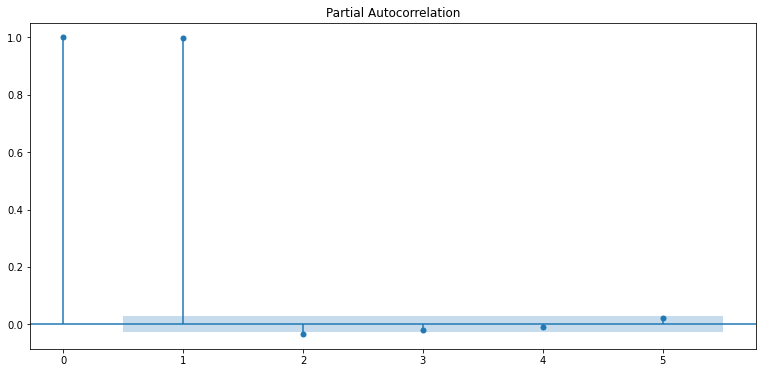

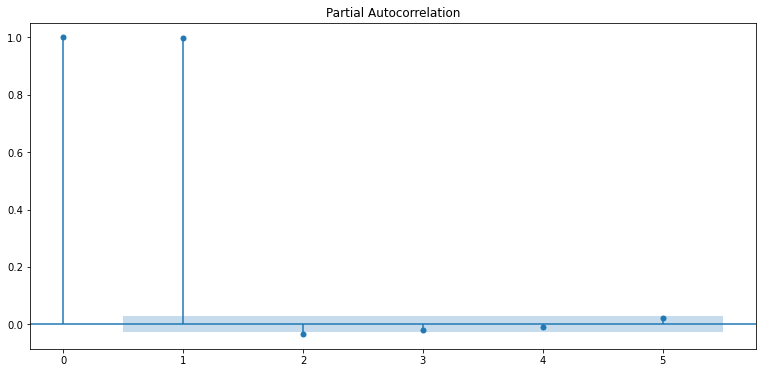

In [35]:
plot_pacf(air_log, lags=5)

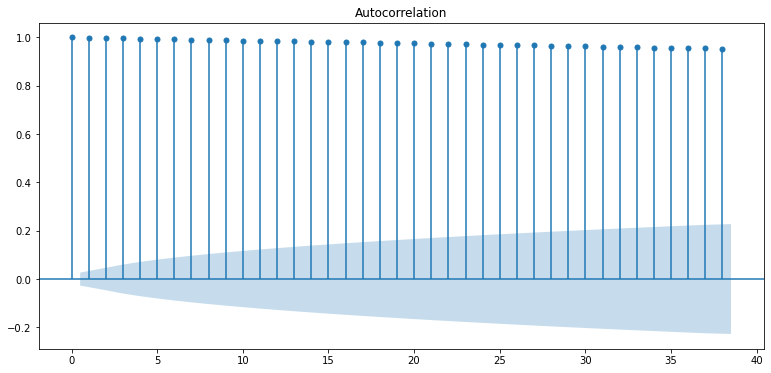

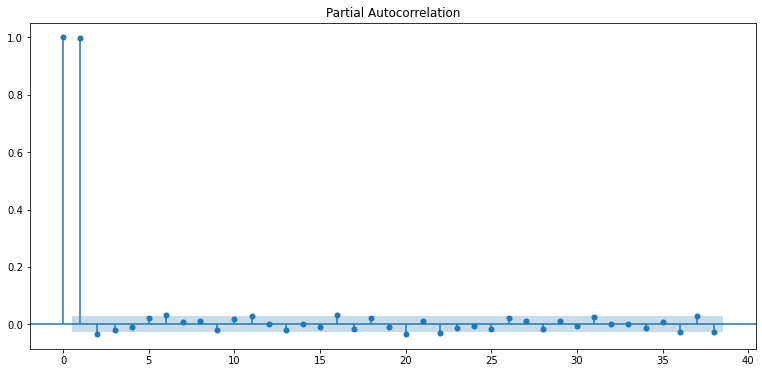

In [36]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(air_log)   
plot_pacf(air_log)  
plt.show()
# acf 천천히 감소
# pcaf 절단값 3,  q=0

Results of Dickey-Fuller Test:
Test Statistic                  -20.724813
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    5303.000000
Critical Value (1%)              -3.431584
Critical Value (5%)              -2.862085
Critical Value (10%)             -2.567060
dtype: float64


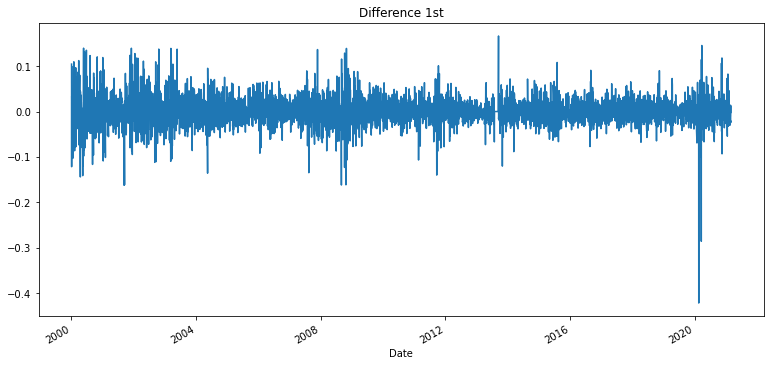

In [37]:
# 1차 차분 구하기
# 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법 = iloc[1:]
# period = 계산위해 이동할 기간(1스탭 몇일)
diff_1 = air_log.diff(periods=1).iloc[1:] 
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 1차 차분에서 안정적이지 않다?의  pvalue 0.0에 근접, >>반대:안정적이다 검증

In [38]:
# p=1,q=0,d=1
model1 = ARIMA(train_data, order=(1, 0, 1))
fitted_air = model1.fit(disp=-1)  
print(fitted_air.summary())

/home/ssac26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 4787
Model:                     ARMA(1, 1)   Log Likelihood               11279.723
Method:                       css-mle   S.D. of innovations              0.023
Date:                Tue, 02 Mar 2021   AIC                         -22551.445
Time:                        20:57:59   BIC                         -22525.551
Sample:                             0   HQIC                        -22542.349
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.6153      0.522     18.437      0.000       8.593      10.637
ar.L1.Close     0.9995      0.000   2454.483      0.000       0.999       1.000
ma.L1.Close     0.0513      0.016      3.309    

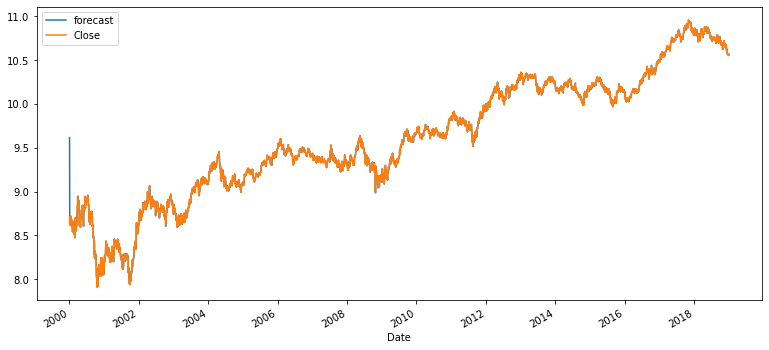

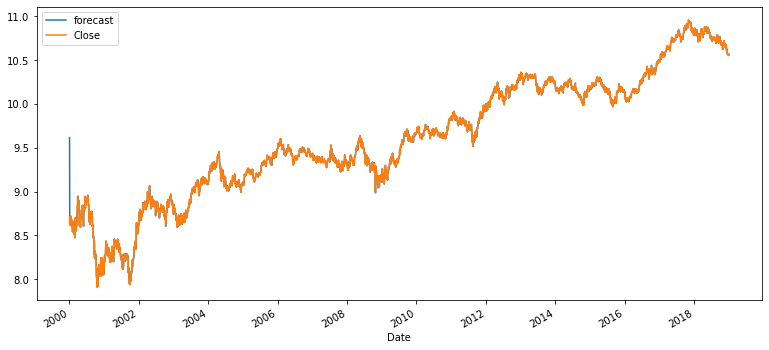

In [39]:
fitted_air.plot_predict()
# 주식그래프의 경우 예측이 종가선에 가려서 잘 안보임..어떻게 수정해야하나

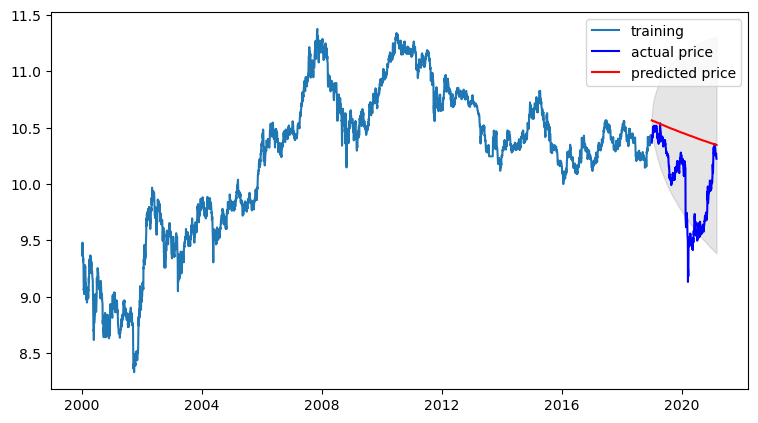

In [40]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_air.forecast(len(test_data_air), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data_air.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data_air.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data_air.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data_air, label='training')
plt.plot(test_data_air, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [41]:
# 코로나로 인한 항공주의 급격한 하락이 있었지만, 모델은 완만한 하락을 예상함

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data_air), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_air), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_air), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data_air))/np.abs(np.exp(test_data_air)))
print('MAPE: {:.2f}%'.format(mape*100))
# mape는 mape*100을 한 백분률로도 가능?

MSE:  164140174.96403277
MAE:  11218.010887838665
RMSE:  12811.720218769717
MAPE: 63.83%


In [43]:
# 항공주 예측엔 완전실패함

## 현대제철

In [44]:
steel = os.getenv('HOME') + '/aiffel/stock_prediction/data/004020.KS.csv'
steel = pd.read_csv(steel, index_col='Date', parse_dates=True)
steel = steel['Close']

steel.head()

Date
2020-03-02    23800.0
2020-03-03    23950.0
2020-03-04    24400.0
2020-03-05    25350.0
2020-03-06    24400.0
Name: Close, dtype: float64

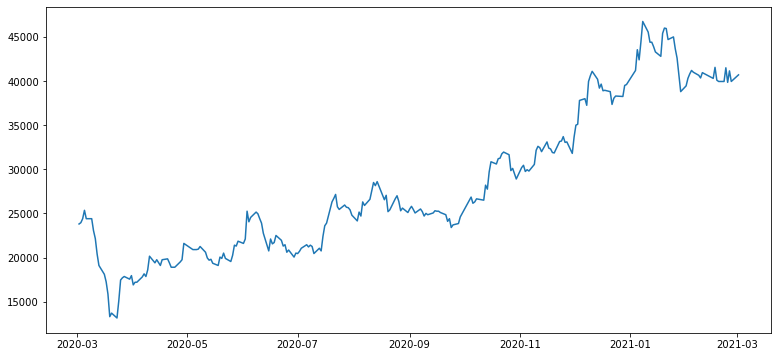

In [45]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    
plt.plot(steel)
# 기본적인 종가차트

In [46]:
steel[steel.isna()]

Series([], Name: Close, dtype: float64)

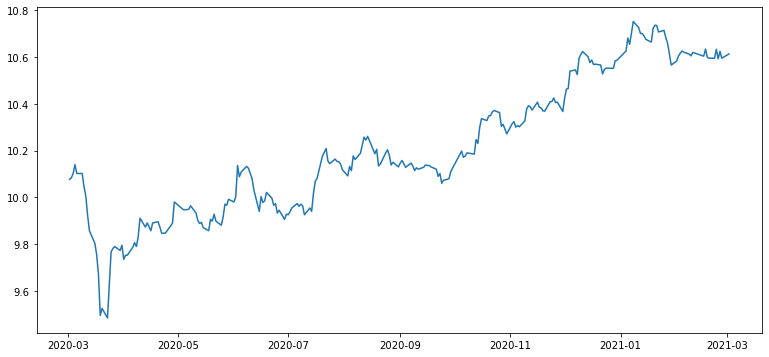

In [47]:
# na없음
steel_log = np.log(steel)
plt.plot(steel_log)

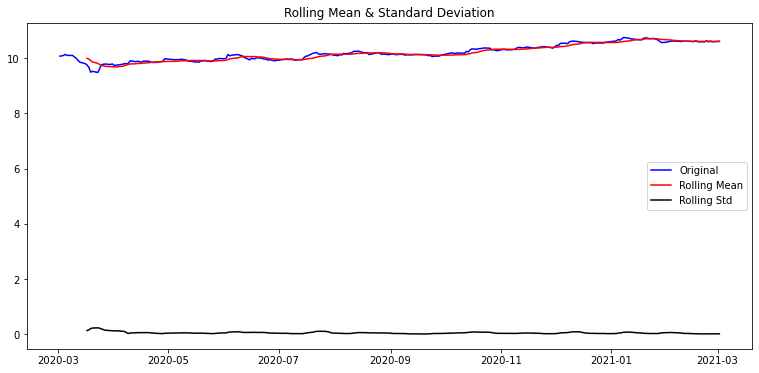

Results of Dickey-Fuller Test:
Test Statistic                  -0.757191
p-value                          0.831375
#Lags Used                       4.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


In [48]:
plot_rolling_statistics(steel_log, window=12)
augmented_dickey_fuller_test(steel_log)
# p값이 높음 >>낮춰야함

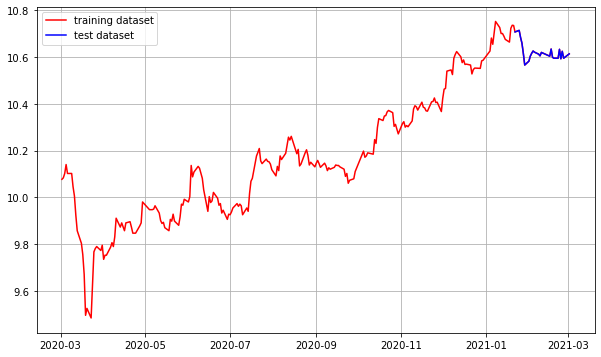

In [49]:
# train/test split
train_data_steel, test_data_steel = steel_log[:int(len(steel_log)*0.9)], steel_log[int(len(steel_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True) # 격자
plt.plot(steel_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data_steel, c='b', label='test dataset')
plt.legend()

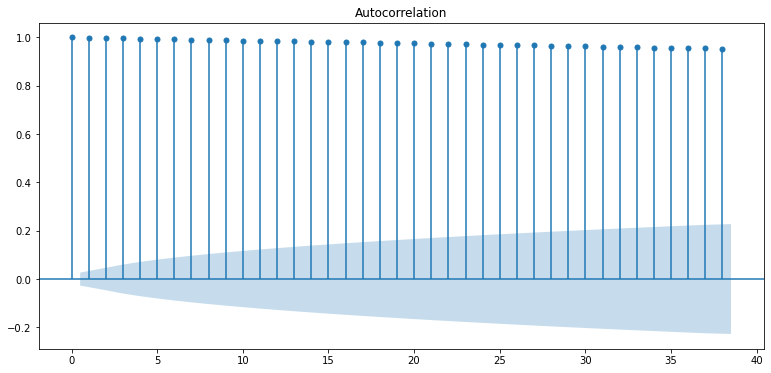

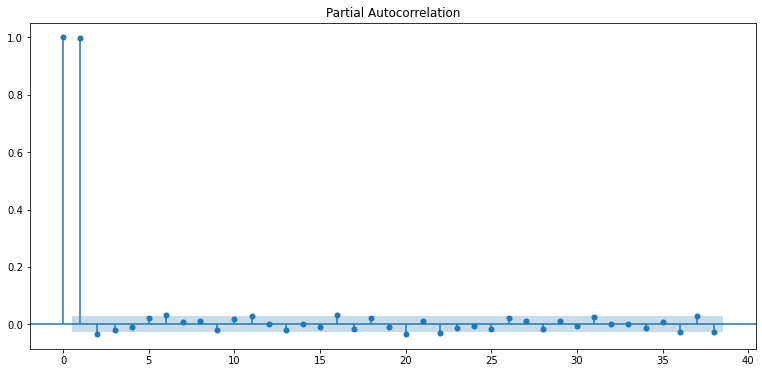

In [50]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(air_log)   
plot_pacf(air_log)  
plt.show()

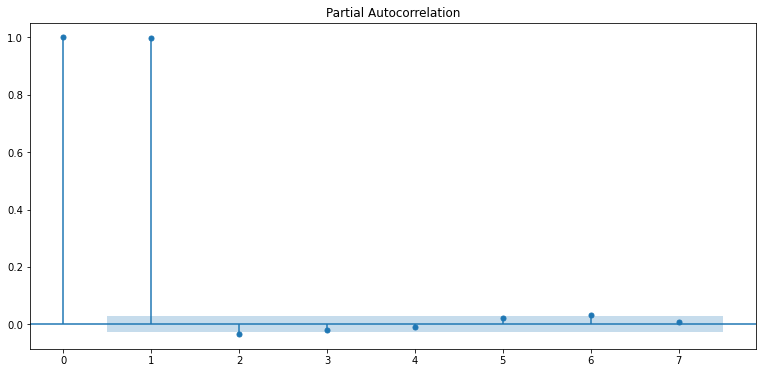

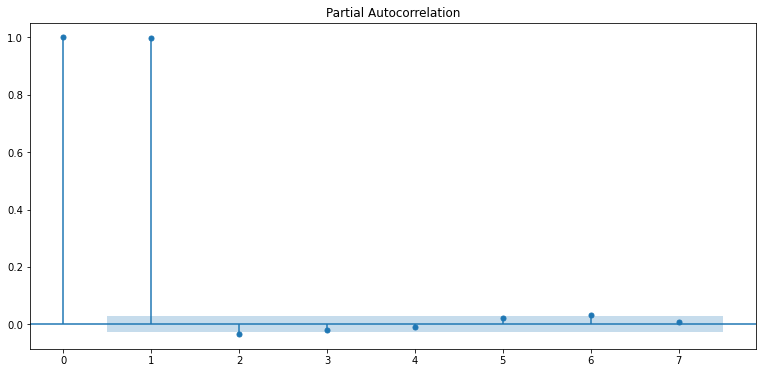

In [51]:
plot_pacf(air_log, lags=7) # 절단값p =2?3, q=0

Results of Dickey-Fuller Test:
Test Statistic                  -20.724813
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    5303.000000
Critical Value (1%)              -3.431584
Critical Value (5%)              -2.862085
Critical Value (10%)             -2.567060
dtype: float64


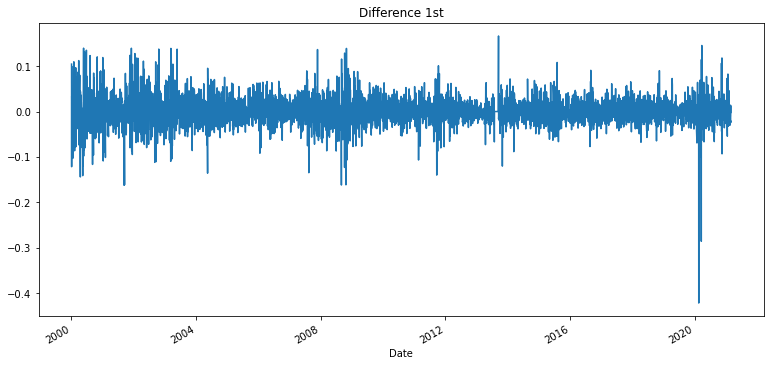

In [52]:
# 1차 차분 구하기
diff_1 = air_log.diff(periods=1).iloc[1:] 
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)
# 1차 차분으로 p-value가 0근사 d=0

In [53]:
# p=2,q=0,d=1
model2 = ARIMA(train_data_steel, order=(1, 0, 1))
fitted_steel = model2.fit(disp=-1)  
print(fitted_steel.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  222
Model:                     ARMA(1, 1)   Log Likelihood                 408.457
Method:                       css-mle   S.D. of innovations              0.038
Date:                Tue, 02 Mar 2021   AIC                           -808.914
Time:                        20:58:02   BIC                           -795.303
Sample:                             0   HQIC                          -803.419
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.2850      0.236     43.514      0.000       9.822      10.748
ar.L1.Close     0.9917      0.008    131.230      0.000       0.977       1.007
ma.L1.Close     0.0732      0.058      1.257    

/home/ssac26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac26/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been prov

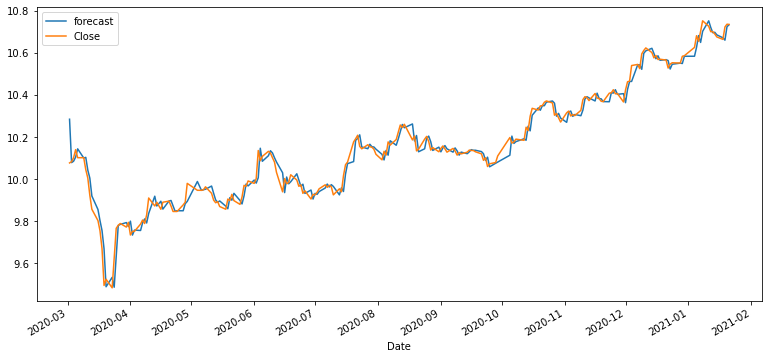

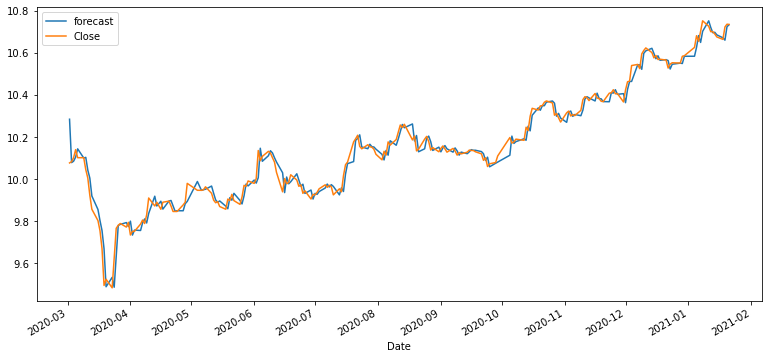

In [54]:
fitted_steel.plot_predict()
# 다른그래프에 비해 등락폭이 급격하지 않아 종가선이 예측을 가리진 않는다.

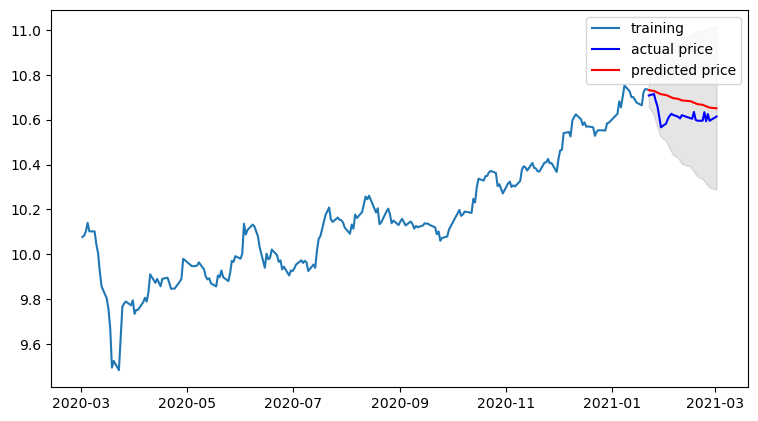

In [55]:
fc, se, conf = fitted_steel.forecast(len(test_data_steel), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data_steel.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data_steel.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data_steel.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data_steel, label='training')
plt.plot(test_data_steel, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [56]:
#완만한 하락과 비슷하게 예측한걸로 그래프상으로 보임
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data_steel), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_steel), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_steel), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data_steel))/np.abs(np.exp(test_data_steel)))
print('MAPE: {:.2f}%'.format(mape*100))
# mape는 mape*100을 한 백분률로도 가능?

MSE:  10045235.516502054
MAE:  2900.211667296921
RMSE:  3169.4219530542246
MAPE: 7.16%


In [57]:
# MAPE가 7%정도의 수치로 여태까지 학습한 모델중 가장 신뢰도가 높다.
# 삼성처럼 기술로 인한 급격한 반등, 항공주같은 대형악재로 인한 급격한 하락은 현재 제공된
# 자료만으론 예측이 힘든것 같다.(삼성30%, 대한65%, 현대7%)
# 실제 주식시장은 변동이 심한데, 현대제철처럼 완만한 주식흐름을 보이는 자료에나 사용가능할것 같다.
